# Read MNIST dataset
The dataset could be downloaded from http://yann.lecun.com/exdb/mnist/

## The raw data format:
* image:  28 x 28 integer [0,1]
* label: integer [0,9]

label: 5;    shape of image: (28, 28)


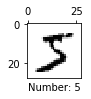

In [19]:
import os
import struct
from matplotlib import pyplot as plt

def read(dataset = "training", path = "."):
    """
    type dataset: string
    type path: string
    rtype: tuple (int, 2d array)
    
    * Python function for importing the MNIST data set. 
    * It returns an iterator of 2-tuples
    * The first element is the label
    * The second element is a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    #for i in range(len(lbl)):
    #    yield get_img(i)
    return (lbl, img)

def show(label, image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure(figsize=(1,1))
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlabel("Number: %d" % label)
    pyplot.show()
    

labels, images = read('training', './data')
label, image = labels[0], images[0]
print("label: %d;   " % label, "shape of image: (%s, %s)" %image.shape)
show(label, image)

images = images.reshape(-1,28*28)
one_hot_labels = np.zeros([labels.shape[0],10])
for i in range(len(labels)):
    one_hot_labels[i][labels[i]] = 1
    

test_labels, test_images = read('testing', './data')
test_images = test_images.reshape(-1,28*28)
test_one_hot_labels = np.zeros([test_labels.shape[0],10])
for i in range(len(test_labels)):
    test_one_hot_labels[i][test_labels[i]] = 1

# Setup Tensorflow KMeans
Use TensorFlow built-in KMeans algorithm: https://www.tensorflow.org/api_docs/python/tf/contrib/factorization/KMeans#training_graph



Important Setups
* **Input placeholder X**: Flatten 28 x 28 pixels to a vector
* **label placeholder Y**: one hot encoder for label (this is not for Kmeans, but defined here for later usage)
* **number of clusters**
* **initial clusters**: 
    * *random*:    choose centers randomly from 'inputs'
    * *kmean++*:    use kmean++ to choose centers from 'inputs'
    * *kmc2*:    use the fast k-MC2 algorithm to choos centers from 'inputs'
* **distance metric**: squared euclidean distance
* **mini batch steps**: 2

In [20]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from tensorflow.contrib.factorization import KMeans

n_features = 28*28
n_classes = 10
X = tf.placeholder(tf.float32, shape=[None, n_features])
Y = tf.placeholder(tf.float32, shape=[None, n_classes])


#%% create an object for generating KMeans clustering graph
kmeans = KMeans(inputs=X, num_clusters=25, distance_metric='cosine', initial_clusters='kmeans_plus_plus',
                use_mini_batch=True, mini_batch_steps_per_iteration=2)

#%% build graph
(all_scores, cluster_idx, scores, cluster_centers_initialized, init_op, training_op) = kmeans.training_graph()
avg_distance = tf.reduce_mean(scores)

cluster_idx = cluster_idx[0]

# Tensorboard Graph
Zoom in graph for details.  

In [18]:
graph = 'D:/Documents/codes/python/python_classification_series/tensorboard_log'
writer = tf.summary.FileWriter(graph, sess.graph)

![pic](tensorboard_kmeans.png)

# Use tensorFlow to do clustering

Step 1:
Initialization. 
Run tf.global_variables_initializer will initialize all global variables as well as placeholders.

Step 2: 
training process

In [21]:
n_steps = 50
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(init_op, feed_dict={X:images})

for i in range(1, n_steps + 1):
    _, d, idx = sess.run([training_op, avg_distance, cluster_idx],
                     feed_dict={X:images})
    if i % 4 == 0 or i == 1:
        print("Step %i, Avg Distance: %f" % (i, d))

Step 1, Avg Distance: 0.317378
Step 4, Avg Distance: 0.227988
Step 8, Avg Distance: 0.219860
Step 12, Avg Distance: 0.217612
Step 16, Avg Distance: 0.216873
Step 20, Avg Distance: 0.216542
Step 24, Avg Distance: 0.216321
Step 28, Avg Distance: 0.216155
Step 32, Avg Distance: 0.216055
Step 36, Avg Distance: 0.215992
Step 40, Avg Distance: 0.215949
Step 44, Avg Distance: 0.215916
Step 48, Avg Distance: 0.215897


In [22]:
# Assign a label to each centroid
# Count total number of labels per centroid, using the label of each training
# sample to their closest centroid (given by 'idx')
counts = np.zeros(shape=(25, 10))
for i in range(len(idx)):
    counts[idx[i]] += one_hot_labels[i]
# Assign the most frequent label to the centroid
labels_map = [np.argmax(c) for c in counts]
labels_map = tf.convert_to_tensor(labels_map)

# Evaluation ops
# Lookup: centroid_id -> label
cluster_label = tf.nn.embedding_lookup(labels_map, cluster_idx)

# Compute accuracy
correct_prediction = tf.equal(cluster_label, tf.cast(tf.argmax(Y, 1), tf.int32))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Test Model
print("Test Accuracy: %.5f" % sess.run(accuracy_op, feed_dict={X: test_images, Y: test_one_hot_labels}))


Test Accuracy: 0.74180


In [23]:
sess.close()